## Repetition Code — Purpose, Usage, and Impact

The **repetition code** is the simplest example of a quantum error-correcting code.  
- It encodes **1 logical qubit** into an **odd number `d` of physical qubits** (e.g. 3, 5, 7).  
- The idea: redundantly store the logical information by repeating the same state across multiple qubits, then use **parity checks** to detect and correct errors.

### Purpose
- Protect quantum information against **bit-flip (X) errors**.
- Provide a clean playground to study **syndrome extraction**, **stabilizer checks**, and **decoding strategies**.
- Serve as a **toy model** for understanding the logic of larger codes (surface codes, LDPC codes, etc.).

### Usage
- **Encoding**: prepare all qubits in the same state (e.g. $|0\rangle^{\otimes d}$ for logical $|0_L\rangle$).  
- **Error detection**: insert ancilla qubits between neighbors to measure **parities** without collapsing the logical state.  
- **Decoding**: compare the measured syndrome history against expected patterns, and infer the most likely error configuration.  
- **Correction**: apply a **Pauli frame update** (track errors in software) or flip the appropriate qubits.

### Errors considered
- The basic repetition code protects only against **X errors** (bit flips).  
- It does **not** protect against **Z (phase) errors** or more general decoherence.  
- In practice, we often assume **i.i.d. X errors** on the data qubits, and study how the logical error rate decreases as the **distance `d`** increases.  
- Measurement errors can also be included, in which case we compare **syndrome differences across rounds** to cancel spurious flips.

### Impact
- The code shows how redundancy + parity checks suppress logical errors: the logical error probability decreases roughly like $p^{(d+1)/2}$ for small $p$.  
- This illustrates the key principle of **fault tolerance**: by increasing code distance, we can make logical qubits arbitrarily reliable, provided the physical error rate is below a threshold.  
- Though the repetition code is not universal (it only handles one type of error), it is a **stepping stone** toward more powerful codes used in real quantum computers.


In [24]:
import sys, time, math
import numpy as np
import matplotlib.pyplot as plt
import sys, os; sys.path.append(os.path.abspath(".."))
from src import distance_d_repetition_code, collect_stats, bits_to_str, decode_min_weight_from_syndrome
from IPython.display import display, SVG
import pandas as pd

## Distance-5 Repetition Code (d = 5, rounds = 4, p = 0.2)

We run the **distance 5 repetition code** with  
- **4 rounds** of syndrome extraction,  
- **bit-flip probability** $p = 0.2$ per data qubit per round.  

The circuit is drawn once, and the experiment is repeated three times to illustrate:  
- how **syndrome outcomes** vary under stronger noise,  
- how the **decoder** tracks and corrects errors,  
- and the difference between **raw** and **corrected** logical results.


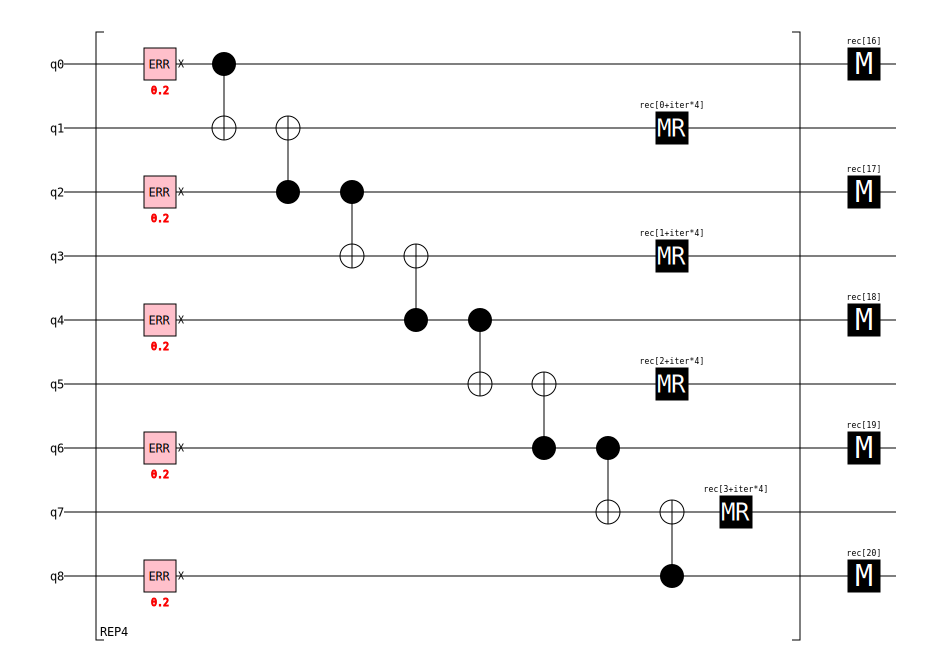


=== Run 1 ===
Round 0: syndrome = ___1
Round 1: syndrome = ___1
Round 2: syndrome = ___1
Round 3: syndrome = ___1
Final data (raw):        ____1
Final data (corrected):  _____
Frame:                   ____1
Raw logical = 0  Corrected logical = 0

=== Run 2 ===
Round 0: syndrome = _1__
Round 1: syndrome = _111
Round 2: syndrome = _111
Round 3: syndrome = _11_
Final data (raw):        11_11
Final data (corrected):  _____
Frame:                   11_11
Raw logical = 1  Corrected logical = 0

=== Run 3 ===
Round 0: syndrome = 1___
Round 1: syndrome = ___1
Round 2: syndrome = ___1
Round 3: syndrome = 11_1
Final data (raw):        _1__1
Final data (corrected):  _____
Frame:                   _1__1
Raw logical = 0  Corrected logical = 0


In [39]:
# Distance-5 repetition code example with syndrome monitoring

d = 5
rounds = 4
p = 0.2

# Draw circuit once
out = distance_d_repetition_code(d, rounds, p)
display(out["SVG"])

# Repeat run 3 times
for run in range(3):
    out = distance_d_repetition_code(d, rounds, p)
    print(f"\n=== Run {run+1} ===")
    S = out["syndromes"].astype(np.uint8)
    for r in range(rounds):
        print(f"Round {r}: syndrome = {bits_to_str(S[r])}")

    print("Final data (raw):       ", bits_to_str(out["data_final"]))
    print("Final data (corrected): ", bits_to_str(out["corrected_data"]))
    print("Frame:                  ", bits_to_str(out["frame"]))
    print("Raw logical =", out["raw_logical"], " Corrected logical =", out["corrected_logical"])


## Custom Loops vs Stim Built-in Shots

Here we compare two approaches for simulating the **distance 5 repetition code** with  
- 100 rounds,  
- error probability $p = 0.02$,  
- 5000 trials.  

- **Custom loops**: run one trial at a time, decoding each record individually.  
- **Stim built-in shots**: use vectorized multi-shot sampling for much faster execution.  

We measure and print both the **logical error rates** and the **runtime** to highlight the efficiency difference.


In [41]:
# Compare custom loops vs Stim's built-in shots

d = 5
rounds = 100
p = 0.02
trials = 5000

import time

t0 = time.perf_counter()
stats_loops = collect_stats(d, rounds, p, trials=trials, fast=False)
t1 = time.perf_counter()
stats_stim  = collect_stats(d, rounds, p, trials=trials, fast=True)
t2 = time.perf_counter()

print("\n--- Speed Comparison ---")
print(f"Custom loops : raw={stats_loops['raw_rate']:.6f}, "
      f"cor={stats_loops['corrected_rate']:.6f}, time={t1-t0:.2f}s")
print(f"Stim shots   : raw={stats_stim['raw_rate']:.6f}, "
      f"cor={stats_stim['corrected_rate']:.6f}, time={t2-t1:.2f}s")


[distance=5, rounds=100, noise=0.02, trials=5000]
Raw logical error rate:       0.487000
Corrected logical error rate: 0.006200
Failures counted:             31/5000
[distance=5, rounds=100, noise=0.02, trials=5000]
Raw logical error rate:       0.483200
Corrected logical error rate: 0.006000
Failures counted:             30/5000

--- Speed Comparison ---
Custom loops : raw=0.487000, cor=0.006200, time=17.37s
Stim shots   : raw=0.483200, cor=0.006000, time=2.79s


## Logical Error Rates vs Noise (Distance-9 Repetition Code)

We now test a **larger code**: distance $d = 9$, with **20 rounds** of syndrome extraction and **10,000 trials** per data point.  

The noise probability $p$ is swept from **0.0 to 0.6** in steps of 0.02.  
For each value of $p$, we record:  
- the **uncorrected logical error rate** (majority vote on final data only),  
- the **corrected logical error rate** (using the Pauli-frame decoder).  

The plot shows how error correction suppresses logical errors compared to raw decoding, and how both degrade as $p$ increases.


[distance=9, rounds=20, noise=0.0, trials=10000]
Raw logical error rate:       0.000000
Corrected logical error rate: 0.000000
Failures counted:             0/10000
[distance=9, rounds=20, noise=0.02, trials=10000]
Raw logical error rate:       0.075100
Corrected logical error rate: 0.000000
Failures counted:             0/10000
[distance=9, rounds=20, noise=0.04, trials=10000]
Raw logical error rate:       0.278000
Corrected logical error rate: 0.000300
Failures counted:             3/10000
[distance=9, rounds=20, noise=0.06, trials=10000]
Raw logical error rate:       0.398600
Corrected logical error rate: 0.002000
Failures counted:             20/10000
[distance=9, rounds=20, noise=0.08, trials=10000]
Raw logical error rate:       0.462800
Corrected logical error rate: 0.004900
Failures counted:             49/10000
[distance=9, rounds=20, noise=0.1, trials=10000]
Raw logical error rate:       0.489800
Corrected logical error rate: 0.019600
Failures counted:             196/10000
[d

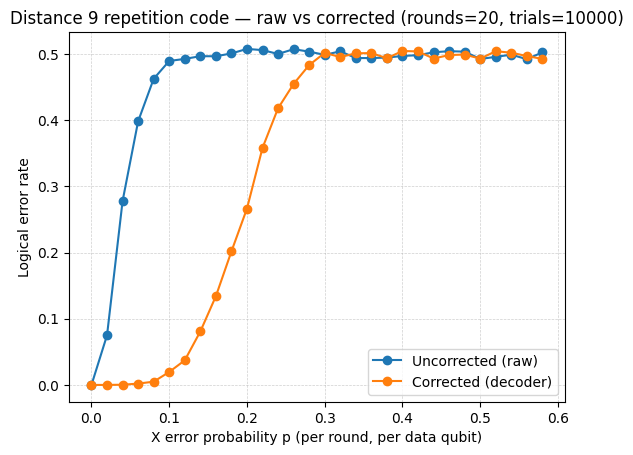

In [ ]:
# Sweep noise for distance-9 repetition code

d = 9
rounds = 20
trials = 10000

ps = np.arange(0.0, 0.60, 0.02)
raw_rates = []
cor_rates = []

for p in ps:
    stats = collect_stats(d, rounds, p, trials=trials, fast=True)
    raw_rates.append(stats["raw_rate"])
    cor_rates.append(stats["corrected_rate"])

import pandas as pd
df = pd.DataFrame({
    "p": ps,
    "raw_rate": raw_rates,
    "corrected_rate": cor_rates,
})
df



plt.figure()
plt.plot(df["p"], df["raw_rate"], marker="o", label="Uncorrected (raw)")
plt.plot(df["p"], df["corrected_rate"], marker="o", label="Corrected (decoder)")
plt.xlabel("X error probability p (per round, per data qubit)")
plt.ylabel("Logical error rate")
plt.title(f"Distance {d} repetition code — raw vs corrected (rounds={rounds}, trials={trials})")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend()
plt.show()

## Distance-21 Repetition Code

Let’s see how the logical error behavior changes when we **increase the code distance to 21**.  
We keep the same setup (20 rounds, 10,000 trials, sweep of noise $p$), and compare **raw vs corrected** logical error rates.


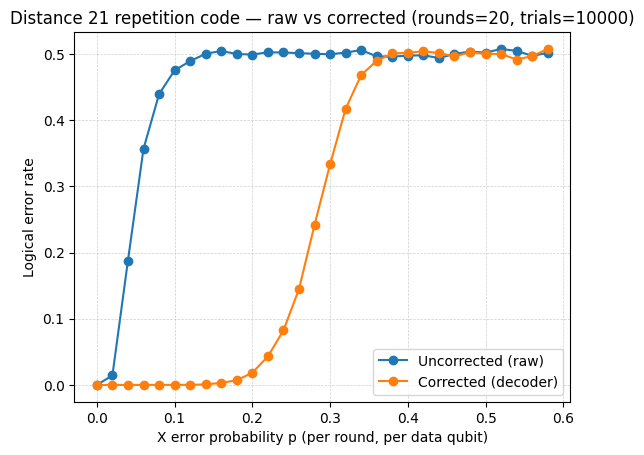

In [53]:
# Sweep noise for distance-21 repetition code (quiet)

d = 21
rounds = 20
trials = 10000

ps = np.arange(0.0, 0.60, 0.02)
raw_rates = []
cor_rates = []

import contextlib, io

for p in ps:
    f = io.StringIO()
    with contextlib.redirect_stdout(f):  # suppress collect_stats prints
        stats = collect_stats(d, rounds, p, trials=trials, fast=True)
    raw_rates.append(stats["raw_rate"])
    cor_rates.append(stats["corrected_rate"])

import pandas as pd
df = pd.DataFrame({
    "p": ps,
    "raw_rate": raw_rates,
    "corrected_rate": cor_rates,
})
df

plt.figure()
plt.plot(df["p"], df["raw_rate"], marker="o", label="Uncorrected (raw)")
plt.plot(df["p"], df["corrected_rate"], marker="o", label="Corrected (decoder)")
plt.xlabel("X error probability p (per round, per data qubit)")
plt.ylabel("Logical error rate")
plt.title(f"Distance {d} repetition code — raw vs corrected (rounds={rounds}, trials={trials})")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend()
plt.show()


## Comparison: Distance-9 vs Distance-21 Repetition Code

The plots compare the logical error rate for **distance 9** and **distance 21** repetition codes, both with  
20 rounds and 10,000 trials, as the physical error probability $p$ increases.

**Key observations:**
- The **raw (uncorrected)** logical error rate (blue) quickly rises toward 0.5 as soon as $p \times rounds > 1$, essentially behaving like a biased coin flip once errors dominate. This is almost the same for both distances.
- The **corrected (decoder)** logical error rate (orange) shifts noticeably to the right when the distance increases:
  - For distance 9, the corrected error rate begins to climb around **$p \sim 0.1$–0.15**.
  - For distance 21, the climb is delayed until around **$p \sim 0.2$–0.25**, showing stronger protection.
- The **threshold-like behavior** is clear: larger distance pushes the onset of logical failure to higher noise values.
- At very large $p$ both codes converge to $\sim 0.5$ logical error, since beyond the threshold error correction cannot keep up.

**Conclusion:**  
Increasing code distance significantly improves robustness against noise, lowering the logical error rate over a wider range of $p$. This is the essence of scaling quantum error correction: larger codes suppress logical errors more effectively, as long as physical error rates remain below threshold.
